In [42]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import azureml
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
from azureml.core.run import Run 
import sys
import os

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import load_model
import numpy as np
from pathlib import Path
import glob2 as glob
import random
import pickle
import cv2

# Display F. Chollet example
from IPython.display import Image, display
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import rescale, resize, downscale_local_mean

from cgmml.common.evaluation.eval_utilities import download_model, get_depthmap_files
from cgmml.common.evaluation.eval_utils import tf_load_pickle
from run_gradcam import show_depthmaps, make_gradcam_heatmaps, show_heatmaps, return_gradcams, remove_batchdim, show_gradcam


In [3]:
REPO_DIR = Path(os.getcwd()).parents[2].absolute()

In [4]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [5]:
output_location = (REPO_DIR / 'data' / 'q3-depthmap-plaincnn-height-95k')

In [6]:
model_file_path = (output_location / 'outputs' / 'best_model.ckpt')
print(model_file_path)

/Users/jasmin/CGM_local/cgm-ml/data/q3-depthmap-plaincnn-height-95k/outputs/best_model.ckpt


In [7]:
height_model = tf.keras.models.load_model(model_file_path, compile=False)

2021-10-06 11:29:28.712148: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-06 11:29:28.712985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# Compile the model.
height_model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
            )

In [ ]:
#height_model.summary()

### Download dataset and find some examples

In [ ]:
# ALREADY DOWNLOADED
#dataset = Dataset.get_by_name(workspace, name='anon-depthmap-mini')
#dataset.download(target_path='./dataset', overwrite=False)

In [9]:
scan_paths = ["./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_000.p", 
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_014.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_000.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_006.p"]

In [10]:
depthmaps = []

for path in scan_paths:
    normalization_value = 7.5
    depthmap, target = tf_load_pickle(path, normalization_value)
    depthmap_np = np.array(depthmap)
    depthmaps.append(depthmap_np)

#print(len(depthmaps))
#print(depthmaps[0])
print(type(depthmaps[0]))
print(depthmaps[0].shape)


<class 'numpy.ndarray'>
(240, 180, 1)


In [ ]:
show_depthmaps(depthmaps)

### Prepare depthmap

In [11]:
#FROM CGM-RG

IMAGE_TARGET_HEIGHT = 240
IMAGE_TARGET_WIDTH = 180
NORMALIZATION_VALUE = 7.5

def preprocess_depthmap(depthmap):
    return depthmap.astype("float32")

def preprocess(depthmap):
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / NORMALIZATION_VALUE
    depthmap = resize(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    depthmap = depthmap.reshape((depthmap.shape[0], depthmap.shape[1], 1))
    return depthmap

In [25]:
preprocessed_depthmaps = []

for depthmap in depthmaps:
    preprocessed_depthmap = preprocess(depthmap)
    preprocessed_depthmap = np.expand_dims(preprocessed_depthmap, axis=0)
    preprocessed_depthmaps.append(preprocessed_depthmap)

print(type(preprocessed_depthmaps))
print(type(preprocessed_depthmaps[0].shape))
print(len(preprocessed_depthmaps))
#print(preprocessed_depthmaps[0])

<class 'list'>
<class 'tuple'>
4


# Create heatmap

In [22]:
# Remove last layer's softmax
height_model.layers[-1].activation = None

#make this a variable - how can I retrieve this from any model??
last_conv_layer_name = 'conv2d_11'

In [29]:
heatmaps = make_gradcam_heatmaps(preprocessed_depthmaps, height_model, last_conv_layer_name)


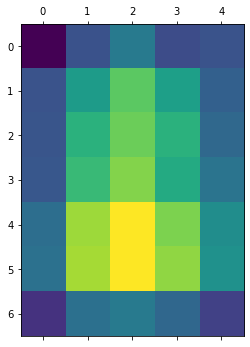

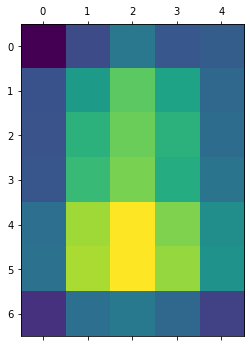

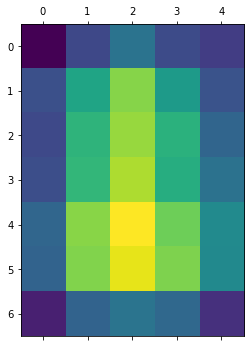

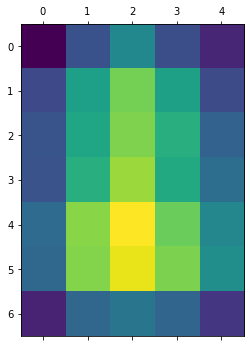

In [30]:
show_heatmaps(heatmaps)

In [34]:
depthmaps_no_batchdim = remove_batchdim(preprocessed_depthmaps)

In [36]:
print(depthmaps_no_batchdim[0].shape)
print(len(depthmaps_no_batchdim))

(240, 180, 1)
4


In [40]:
superimposed_imgs = return_gradcams(depthmaps_no_batchdim, heatmaps, transparency=0.3)

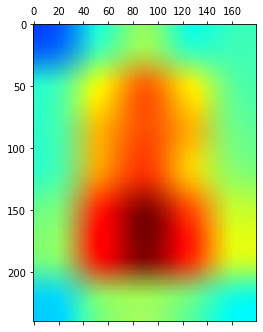

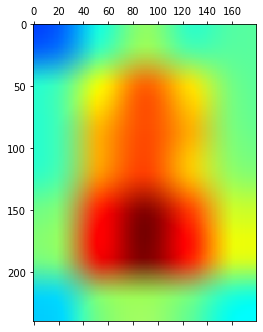

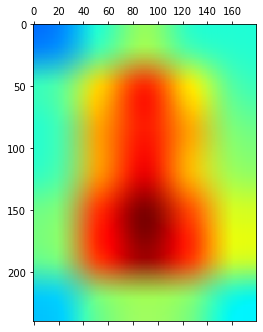

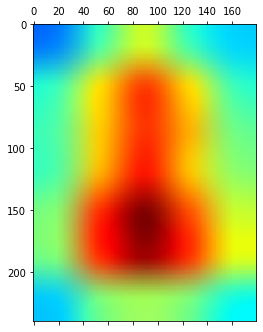

In [43]:
show_gradcam(superimposed_imgs)

# CGM-RG: Height Flow - adapt inference.get_height_predictions_local

In [ ]:
#class HeightFlowPlainCnn(HeightFlow):
#    def run_flow(self):
#        depthmaps = preprocessing.process_depthmaps(self.artifacts, self.scan_directory, self.result_generation)
#        height_predictions = inference.get_height_predictions_local(depthmaps)
#        generated_timestamp = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')
#        self.post_height_results(height_predictions, generated_timestamp)

#def get_height_predictions_local(numpy_array):
#    return height_model.predict(numpy_array)

## re-write get_height_predictions_local to get_height_prediction_and_heatmap_local

In [63]:
def get_height_pred_local_and_gradcam(numpy_array):
    height_prediction = height_model.predict(numpy_array)
    #do gradcam
    #note: load_model is called in cgm-rg - but I still had to do the compilation stuff "manually" to get gradcam work
    # Remove last layer's softmax
    height_model.layers[-1].activation = None 
    last_conv_layer_name = 'conv2d_11'  # How can I retrieve this for different models dynamically?
    #numpy_array = np.expand_dims(numpy_array, axis=0)
    print(numpy_array.shape)
    heatmap = make_gradcam_heatmaps(numpy_array, height_model, last_conv_layer_name)  # where do we put this function make_gradcam_heatmap
    numpy_array_nobatch = remove_batchdim(preprocessed_depthmaps)
    gradcam = return_gradcams(numpy_array_nobatch, heatmap, transparency=0.3)
    
    return height_prediction, gradcam

## HOW can I dynamically get the name of the last conv layer

In [64]:
#for depthmap in preprocessed_depthmaps:

test_height_prediction, test_gradcam = get_height_pred_local_and_gradcam(depthmap)

(1, 240, 180, 1)


ValueError: Input 0 is incompatible with layer model_15: expected shape=(None, 240, 180, 1), found shape=(240, 180, 1)